In [5]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import math

# Preprocessing

In [6]:
import copy

class person:
    """
    The item class, which record the change of the properties and the customer
    of the item
    """
    def __init__(self, id):
        self.person_id = id

        self.purchased_items = []
        self.viewed_items = []
        self.cart_items = []

    def purchase(self, item_id, transcation_id, timestamp):
        """
        record a purchase
        :param item_id: str
        :param transcation_id: str
        :param timestamp: str
        :return: None
        """
        self.purchased_items.append((item_id, transcation_id, timestamp))
    def view(self, item_id, timestamp):
        """
        record a view
        :param item_id: str
        :param timestamp: str
        :return: None
        """
        self.viewed_items.append((item_id,timestamp))
    def add_to_cart(self, item_id, timestamp):
        """
        record a add_to_cart
        :param item_id: str
        :param timestamp: str
        :return: None
        """
        self.cart_items.append((item_id,timestamp))
    def purchases_record(self):
        """
        return the record of the purchases of the person
        :return: list
        """
        return self.purchased_items
    def carts_record(self):
        """
        return the record of items have been added to the cart
        :return: list
        """
        return self.cart_items
    def views_record(self):
        """
        return the record of what the person have viewed
        :return: list
        """
        return self.viewed_items

In [7]:
class item:
    """
    The item class, which record the change of the properties and the customer
    of the item
    """
    def __init__(self, id):
        self.item_id = id
        self.properties = {}
        self.customers = []
        self.viewers = []
        self.cart_adders = []
    def property_change(self, pro_name, value, timestamp):
        """
        record a change of a property
        :param pro_name: str
        :param value: str
        :param timestamp: str
        :return:
        """
        if pro_name not in self.properties:
            self.properties[pro_name] = []
        self.properties[pro_name].append((value, timestamp))
    def purchase(self, customerID, transcation_id,timestamp):
        """
        record a purchase
        :param customerID: str
        :param transcation_id: str
        :param timestamp: str
        :return: None
        """
        self.customers.append((customerID,transcation_id, timestamp))
    def view(self, customerID, timestamp):
        """
        record a view
        :param customerID: str
        :param timestamp: str
        :return: None
        """
        self.viewers.append((customerID,timestamp))
    def add_to_cart(self, customerID, timestamp):
        """
        record a add_to_cart
        :param customerID: str
        :param timestamp: str
        :return: None
        """
        self.cart_adders.append((customerID,timestamp))
    def customers_record(self):
        """
        return the record of customers of the item
        :return: list
        """
        return self.customers
    def carts_record(self):
        """
        return the record of persons who added this item to the cart
        :return: list
        """
        return self.cart_adders
    def viewers_record(self):
        """
        return the record of persons who viewed this item
        :return: list
        """
        return self.viewers
    def property_record(self, pro_name):
        """
        return the record of a property of the item
        :param pro_name: str
        :return: list
        """
        return self.properties[pro_name]

In [8]:
class analyse():
    """
    the class to read and store data
    """
    def __init__(self):
        self.persons = {}
        self.items = {}
    def read_property(self, property_file):
        f, first = open(property_file, "r"), True
        for line in f:
            if first:
                first = False
                continue
            property_info = line.split(",")
            timestamp, item_id, pro_name, value = property_info[0], property_info[1], property_info[2], property_info[3]
            if item_id not in self.items:
                continue
                self.items[item_id] = item(item_id)
            self.items[item_id].property_change(pro_name, value, timestamp)
    def read_event(self, event_file):
        f, first = open(event_file, "r"), True
        for line in f:
            if first:
                first = False
                continue
            event_info = line.split(",")
            timestamp, person_id, event, item_id, transaction_id = datetime.datetime.strptime(event_info[0], '%Y-%m-%d'), event_info[1], event_info[2], event_info[3], event_info[4]
            if person_id not in self.persons:
                self.persons[person_id] = person(person_id)
            if item_id not in self.items:
                self.items[item_id] = item(item_id)
            if event == "transaction":
                self.persons[person_id].purchase(item_id, transaction_id, timestamp)
                self.items[item_id].purchase(person_id, transaction_id,timestamp)
            elif event == "view":
                self.persons[person_id].view(item_id, timestamp)
                self.items[item_id].view(person_id, timestamp)
            else:
                self.persons[person_id].add_to_cart(item_id, timestamp)
                self.items[item_id].add_to_cart(person_id, timestamp)





a = analyse()
a.read_event("/Users/nihaozheng/Desktop/Personalization/project/retailrocket-recommender-system-dataset/events_cleaned_time.csv")
a.read_property("/Users/nihaozheng/Desktop/Personalization/project/retailrocket-recommender-system-dataset/item_properties_part1.csv")
a.read_property("/Users/nihaozheng/Desktop/Personalization/project/retailrocket-recommender-system-dataset/item_properties_part2.csv")



In [9]:
def subset(threshold):
    """
    preprocess users in a, filter the users according to its purchased, viewd, and carted items
    :param threshold: int
    :return: {}
    """
    res = {}
    for person_name, person in a.persons.items():
        if len(person.viewed_items) + len(person.cart_items) > threshold and len(person.purchased_items) > threshold:
            res[person_name] = copy.deepcopy(person)
    return res

In [10]:
def subset_item(persons):
    """
    preprocess users, filter the users according to its purchased, viewd, and carted items
    :param person: {}
    :return: {}
    """
    res = {}
    for person_name, person in persons.items():
        
        for item in person.viewed_items + person.purchased_items + person.cart_items:
            
            if item[0] not in res:
                res[item[0]] = res.get(item[0], 0) + 1
                
    return res

In [11]:
def merge(item_after_subset):
    """
    merge items with same categoryid
    :param person: {}
    :return: {}
    """
    sec_subset_item = {}
    for item in item_after_subset:
        if "categoryid" not in a.items[item].properties:
            sec_subset_item[item] = copy.deepcopy(a.items[item])
            continue
        category_id = a.items[item].property_record("categoryid")[0][0][:-1]
        if category_id not in sec_subset_item:
            sec_subset_item[category_id] = copy.deepcopy(a.items[item])
            sec_subset_item[category_id].item_id = category_id
        else:
            for pro_name, values in a.items[item].properties.items():
                if pro_name not in sec_subset_item[category_id].properties:
                    sec_subset_item[category_id].properties[pro_name] = []
                sec_subset_item[category_id].properties[pro_name] += values
            sec_subset_item[category_id].viewers += a.items[item].viewers
            sec_subset_item[category_id].customers += a.items[item].customers
            sec_subset_item[category_id].cart_adders += a.items[item].cart_adders
    return sec_subset_item

In [12]:
user_dic1, user_dic2 = subset(1), subset(2)
print(len(user_dic1), len(user_dic2))

2549 1016


In [13]:
item_sub_dic1,item_sub_dic2 = subset_item(user_dic1), subset_item(user_dic2)
print(len(item_sub_dic1), len(item_sub_dic2))

30601 27487


In [14]:
merged_items1, merged_items2 = merge(item_sub_dic1), merge(item_sub_dic2)
print(len(merged_items1), len(merged_items2))

2019 1957


In [15]:
def update_items_in_persons(subset_persons):
    """
    update items' ids recorded in filtered users with categoryid
    :param subset_persons: {}
    :param merged_items: {}
    :return: None
    """
    
    for person_name, person in subset_persons.items():
        for index in range(len(person.viewed_items)):
            if "categoryid" in a.items[person.viewed_items[index][0]].properties:
                category_id = a.items[person.viewed_items[index][0]].properties["categoryid"][0][0][:-1]
                time_stamp = person.viewed_items[index][1]
                person.viewed_items[index] = (category_id, time_stamp)
                
        for index in range(len(person.purchased_items)):
            if "categoryid" in a.items[person.purchased_items[index][0]].properties:
                category_id = a.items[person.purchased_items[index][0]].properties["categoryid"][0][0][:-1]
                time_stamp = person.purchased_items[index][2]
                transaction_id = person.purchased_items[index][1]
                person.purchased_items[index] = (category_id ,transaction_id, time_stamp)
        for index in range(len(person.cart_items)):
            if "categoryid" in a.items[person.cart_items[index][0]].properties:
                category_id = a.items[person.cart_items[index][0]].properties["categoryid"][0][0][:-1]
                time_stamp = person.cart_items[index][1]
                person.cart_items[index] = (category_id, time_stamp)

In [16]:
update_items_in_persons(user_dic2)

In [17]:
len(user_dic2)

1016

# Change user_dic to a readable format for the timesvd++ functions

In [18]:
# map all users and items to natural number starting from 1:
i = 1
j = 1
user_dict ={}
item_dict = {}
for user in user_dic2:
    user_dict[user] = i
    i = i +1
    for record in user_dic2[user].purchases_record():
        if record[0] not in item_dict.keys():
            item_dict[record[0]] = j
            j = j +1
    for record in user_dic2[user].carts_record():
        if record[0] not in item_dict.keys():
            item_dict[record[0]] = j
            j = j +1
    for record in user_dic2[user].views_record():
        if record[0] not in item_dict.keys():
            item_dict[record[0]] = j
            j = j +1


In [19]:
R = {}
for user in user_dic2:
    R[user_dict[user]]=[]
    item =[]
    action = []
    time =[]
    for record in user_dic2[user].purchases_record():
        item.append(item_dict[record[0]])
        action.append(5)
        time.append(record[2])
    for record in user_dic2[user].carts_record():
        item.append(item_dict[record[0]])
        action.append(2)
        time.append(record[1])
    for record in user_dic2[user].carts_record():
        item.append(item_dict[record[0]])
        action.append(1)
        time.append(record[1])
    summary = pd.DataFrame({'item':item,'action':action,'time':time},columns=['item','action','time'])
    summary.sort_values(by='time',inplace=True)
    for record in summary.itertuples():
        l = [record[1],record[2],record[3]]
        if l not in R[user_dict[user]]:
            R[user_dict[user]].append(l)

# Train-Test split

In [20]:
def split(data,ratio):
    train ={}
    test ={}
    for user in data.keys():
        train[user]=[]
        test[user]=[]
        n = len(data[user])
        reserve = int(ratio*n)
        #all items in test set must be seen before
        l1 = data[user][:reserve]
        l2 = data[user][reserve:]
        l1_item = [r[0] for r in l1]
        for r in l2:
            if r[0] not in l1_item:
                l1.append(r)
                l2.remove(r)

        train[user] = l1
        test[user]=l2
    return train,test
        
        

In [21]:
train,test = split(R,0.8)

In [22]:
train,valid = split(train,0.8)

In [24]:
id = list(train.keys())
re = [train[key] for key in id]

In [25]:
train_table=pd.DataFrame({'id':id,'item':re})

In [26]:
id = list(valid.keys())
re = [valid[key] for key in id]
valid_table=pd.DataFrame({'id':id,'item':re})

In [27]:
id = list(test.keys())
re = [test[key] for key in id]
test_table=pd.DataFrame({'id':id,'item':re})

In [28]:
#train_table.to_csv('/Users/nihaozheng/Desktop/Personalization/project/project II/train.csv',index=False)
#valid_table.to_csv('/Users/nihaozheng/Desktop/Personalization/project/project II/validation.csv',index=False)
#test_table.to_csv('/Users/nihaozheng/Desktop/Personalization/project/project II/test.csv',index=False)

## Time SVD

In [29]:
class time_svd():
    def __init__(self, userItems, nFactors, nBins,beta, lr, iterations):
        '''
        Initialize paramters in the model
        
        Arguments
        - userItems   : user-item dictionaries
            e.g. user1:[[item1,rating,timestamp],[item2,rating,timestamp]]...
        - nFactors (int) : number of lantent factors 
        - nBins(int) : Number of bins to divide timestemps
        - beta: Power in the definition of dev(t)
        - lr (float) : learning rate in sgd
        - iterations : number of sgd performed
        
        '''
        self.userItems = userItems
        self.factors = nFactors
        self.lr = lr
        self.iterations = iterations
        self.nBins = nBins
        self.beta =beta
        start_end_time = {}
        self.all_dates = set()
        for person in userItems.keys():
            start_end_time[person] = []
            start = R[person][0][2]
            end =R[person][-1][2]
            t =[r[2] for r in R[person]] 
            length = (end-start).days
            start_end_time[person] += [start,end,length]
            self.all_dates.update(t)
        
        self.all_dates = list(self.all_dates)
        self.all_dates.sort()
        start = [i[1][0] for i in start_end_time.items() ]
        end = [i[1][1] for i in start_end_time.items() ]
        self.nDays = (max(end)-min(start)).days+1
        self.start = min(start)
        self.end = max(end)
        
        #------------------parameters in timesvd -----------------------'
        
        #initialize self.mu as average rating of all records:
        n = 0
        rate = []
        for user in userItems.keys():
            for record in userItems[user]:
                n += 1
                rate.append(record[1])
        self.mu = sum(rate)/n
        
        nUsers = len(userItems.keys())
        items = set()
        for user in R.keys():
            l = [i[0] for i in R[user]]
            items.update(l)
        nItems = max(items)
        
        #initialize other parameters from U[0,1]        
        
        #biases
        self.bu = np.random.uniform(0, 1, nUsers + 1)
        self.bi = np.random.uniform(0,1, nItems + 1) # dtype = 'float64'

        # bi_bin = np.random.random((nItems + 1, nBins))
        self.bi_bin = []
        for b in range(nItems + 1):
            bii = np.random.uniform(0, 1, nBins)
            self.bi_bin.append(bii)

        self.alpha_u = np.random.uniform(0, 1, nUsers + 1) # nUsers + 1, dtype = 'float64'

        self.bu_t = np.zeros((nUsers + 1, self.nDays), dtype = 'float64')

        #factors
        # userFactors = np.random.random((nUsers + 1, nFactors))
        self.userFactors = []
        for b in range(nUsers + 1):
            bii = np.random.uniform(0, 1, nFactors)
            self.userFactors.append(bii)

        # itemFactors = np.random.random((nItems + 1, nFactors))
        self.itemFactors = []
        for b in range(nItems + 1):
            bii = np.random.uniform(0, 1, nFactors)
            self.itemFactors.append(bii)



        # sumMW = np.random.random((nUsers + 1, nFactors))
        self.sumMW = []
        for b in range(nUsers + 1):
            bii = np.random.uniform(0, 1, nFactors)
            self.sumMW.append(bii)

        #time-based parameters
        # alpha_u_k = np.random.random((nUsers + 1, nFactors))
        self.alpha_u_k = []
        for b in range(nUsers + 1):
            bii = np.random.uniform(0, 1, nFactors)
            self.alpha_u_k.append(bii)

        self.userFactors_t = np.zeros((nUsers + 1, nFactors, self.nDays))
    
    def date_map(self,timestamp):
        '''
        Map each timestamp to natural number starting from 0:
        
        '''
        index = self.all_dates.index(timestamp)
        return index
        
    def prediction(self,userId,itemId,timestamp_):
        """
        Get the predicted rating of user i and item j at timestamp_
        """
        #print('user id is {}, date is {}".format(userId,self.date_map(timestamp_)))
        bi_ = self.bi[itemId]
        bit_ =  self.bi_bin[itemId][self.calBin(timestamp_)]
        bu_ = self.bu[userId]
        but_ = self.bu_t[userId][self.date_map(timestamp_)]
        au = self.alpha_u[userId]
        dev_ = self.dev(userId, timestamp_)
        #baseline
        prediction = self.mu + bi_ + bit_ + bu_ + au * dev_+ but_
        #add user-item interaction
        for k in range(self.factors):
            u_f = self.userFactors[userId][k]
            u_f_t = self.userFactors_t[userId][k][self.date_map(timestamp_)]
            auk = self.alpha_u_k[userId][k]
            i_f = self.itemFactors[itemId][k]

            # item factor
            pukt = u_f + auk * dev_ + u_f_t
            prediction += i_f * pukt
        return prediction

    def prediction_baseline(self,userId,itemId,timestamp_):
        """
        Get the predicted rating of user i and item j at timestamp_ for baseline model
        """
        #print('user id is {}, date is {}".format(userId,self.date_map(timestamp_)))
        bi_ = self.bi[itemId]
        bit_ =  self.bi_bin[itemId][self.calBin(timestamp_)]
        bu_ = self.bu[userId]
        but_ = self.bu_t[userId][self.date_map(timestamp_)]
        au = self.alpha_u[userId]
        dev_ = self.dev(userId, timestamp_)
        #baseline
        prediction = self.mu + bi_ + bit_ + bu_ + au * dev_+ but_
        return prediction
    
    def baseline(self):
        '''
        Train the baseline timesvd by sgd
        '''
        for userId, v in self.userItems.items():
        #tmpSum = np.zeros(self.factors, dtype='float')

        # if userId not in self.training_userItems:
         #   continue
            #print(userId)
            sz = len(self.userItems[userId])

            if sz > 0:
                sqrtNum = 1/(math.sqrt(sz))
                for it in range(sz):
                    itemId = self.userItems[userId][it][0]
                    rating = self.userItems[userId][it][1]
                    timestamp_ = self.userItems[userId][it][2]

                    li = [userId, itemId, rating, timestamp_]

                    prediction = self.prediction_baseline(userId, itemId, timestamp_)
                    error = rating - prediction
                    bi_ = self.bi[itemId]
                    bit_ =  self.bi_bin[itemId][self.calBin(timestamp_)]
                    bu_ = self.bu[userId]
                    

                    but_ = self.bu_t[userId][self.date_map(timestamp_)]
                    au = self.alpha_u[userId]
                    dev_ = self.dev(userId, timestamp_)
                   
                    # print ('error = ', error)
                    # user bias
                    sgd = error + 0.01 * bu_
                    self.bu[userId] += -0.01 * sgd

                    # item bias
                    sgd = error + 0.01 *bi_
                    self.bi[itemId] += -0.01 * sgd


                    # item bias bi, bin(t)
                    #calBin is the bin number that this timestamp falls in
                    sgd = error + 0.01 * bit_
                    self.bi_bin[itemId][self.calBin(timestamp_)] += -0.01 * sgd

                    # cu is the scale preference changing through time, which we don't consider it here
                    """sgd = error * (bi_ + bit_) - 0.01 * cu_
                    self.cu[userId] += 0.01 * sgd

                    #cu_t
                    sgd = error * (bi_ + bit_) - 0.01 * cut_
                    self.cu_t[userId][timestamp_] += 0.01 * sgd"""

                    # bu_t
                    sgd = error + 0.01 * but_
                    delta = but_ - 0.01 * sgd
                    self.bu_t[userId][self.date_map(timestamp_)] = delta

                    # au
                    sgd = error * dev_ + 0.01 * au
                    self.alpha_u[userId] += -0.01 * sgd




    def train(self):
        '''
        Train the timesvd by sgd
        '''
        for userId, v in self.userItems.items():
        #tmpSum = np.zeros(self.factors, dtype='float')

        # if userId not in self.training_userItems:
         #   continue
            #print(userId)
            sz = len(self.userItems[userId])

            if sz > 0:
                sqrtNum = 1/(math.sqrt(sz))
                for it in range(sz):
                    itemId = self.userItems[userId][it][0]
                    rating = self.userItems[userId][it][1]
                    timestamp_ = self.userItems[userId][it][2]

                    li = [userId, itemId, rating, timestamp_]

                    prediction = self.prediction(userId, itemId, timestamp_)
                    error = rating - prediction
                    bi_ = self.bi[itemId]
                    bit_ =  self.bi_bin[itemId][self.calBin(timestamp_)]
                    bu_ = self.bu[userId]
                    

                    but_ = self.bu_t[userId][self.date_map(timestamp_)]
                    au = self.alpha_u[userId]
                    dev_ = self.dev(userId, timestamp_)
                   
                    # print ('error = ', error)
                    # user bias
                    sgd = error + 0.01 * bu_
                    self.bu[userId] += -0.01 * sgd

                    # item bias
                    sgd = error + 0.01 *bi_
                    self.bi[itemId] += -0.01 * sgd


                    # item bias bi, bin(t)
                    #calBin is the bin number that this timestamp falls in
                    sgd = error + 0.01 * bit_
                    self.bi_bin[itemId][self.calBin(timestamp_)] += -0.01 * sgd

                    # cu is the scale preference changing through time, which we don't consider it here
                    """sgd = error * (bi_ + bit_) - 0.01 * cu_
                    self.cu[userId] += 0.01 * sgd

                    #cu_t
                    sgd = error * (bi_ + bit_) - 0.01 * cut_
                    self.cu_t[userId][timestamp_] += 0.01 * sgd"""

                    # bu_t
                    sgd = error + 0.01 * but_
                    delta = but_ - 0.01 * sgd
                    self.bu_t[userId][self.date_map(timestamp_)] = delta

                    # au
                    sgd = error * dev_ + 0.01 * au
                    self.alpha_u[userId] += -0.01 * sgd


                    # updating factors
                    for k in range(self.factors):
                        u_f = self.userFactors[userId][k]
                        i_f = self.itemFactors[itemId][k]
                        u_f_t = self.userFactors_t[userId][k][self.date_map(timestamp_)]
                        auk = self.alpha_u_k[userId][k]

                        # item factor
                        pukt = u_f + auk * dev_ + u_f_t

                        '''
                        sum_yk = 0
                        for j in range(sz):
                            pos_item = self.userItems[userId][j][0]
                            sum_yk += self.y_j[pos_item][k]
                        '''


                        sgd = error * pukt  + 0.01 * i_f
                        self.itemFactors[itemId][k] += -0.01 * sgd

                        #update user factor
                        sgd = error * i_f + 0.01 * u_f
                        self.userFactors[userId][k] += -0.01 * sgd

                        # auk
                        sgd  = error * i_f * dev_ + 0.01 * auk
                        self.alpha_u_k[userId][k] += -0.01 * sgd

                        # uf_t
                        sgd = error * i_f + 0.01 * u_f_t
                        delta = u_f_t - 0.01 * sgd
                        self.userFactors_t[userId][k][self.date_map(timestamp_)] = delta

                
    def calBin(self,timestamp):
        
        '''
        Calculate the bin number for each timestamp
        '''
        bin_width = self.nDays/self.nBins
        bin_number = int((timestamp - self.start).days/bin_width)
        if bin_number==self.nBins:
            return self.nBins-1
        return bin_number
    
    def dev(self,userId, timestamp):
        user_date = [i[2] for i in self.userItems[userId]]
        user_date.sort()
        mean_date = user_date[round(len(user_date)/2)]

        diff = (timestamp-mean_date).days
        sign = np.sign(diff)
        dev = sign*pow(abs(diff),self.beta)
        
        return dev
        
        




In [30]:
def cv(train,valid):
    log = []
    best_rate = 0
    best_model =[]
    for nFactors in [2,3,4,5,6,7,8,9,10,15,20,30]:
        for nBins in [5,10,15,20,30]:
            for beta in [0.01,0.05,0.1,0.3,0.5]:
                for lr in [0.01,0.03,0.05,0.1,0.5]:
                    for iterations in [10,20,30,50,100]:
                        print("nFactors={},nBins={},beta={},lr={},iterations={}".format(nFactors,nBins,beta,lr,iterations))
                        total = 0
                        hit = 0
                        temp = time_svd(userItems=train, nFactors=nFactors, nBins=nBins, beta = beta, 
                                        lr=lr, iterations=iterations)
                        for user in valid.keys():
                            for record in valid[user]:
                                total += 1
                                pred = temp.prediction(user,record[0],record[2])
                                if pred >= 5 and record[1]==5:
                                    hit += 1
                                elif pred < 5 and record[1] < 5:
                                    hit += 1
                        print(hit/total)
                        log.append([nFactors,nBins,beta,lr,iterations,hit/total])
                        if hit/total > best_rate:
                            best_model = [nFactors,nBins,beta,lr,iterations]
                            best_rate = hit/total
    return best_model,best_rate,log




# This line is cross validation, it can take several hours from your life!

In [31]:
best_model,best_rate,log=cv(train,valid)

nFactors=2,nBins=5,beta=0.01,lr=0.01,iterations=10
0.4976452119309262
nFactors=2,nBins=5,beta=0.01,lr=0.01,iterations=20
0.48953427524856097
nFactors=2,nBins=5,beta=0.01,lr=0.01,iterations=30
0.47802197802197804
nFactors=2,nBins=5,beta=0.01,lr=0.01,iterations=50
0.52145473574045
nFactors=2,nBins=5,beta=0.01,lr=0.01,iterations=100
0.5013082155939299
nFactors=2,nBins=5,beta=0.01,lr=0.03,iterations=10


KeyboardInterrupt: 

In [ ]:
best_rate

In [32]:
def cv_baseline(train,valid):
    log = []
    best_rate = 0
    best_model =[]
    for nFactors in [2,3,4,5,6,7,8,9,10,15,20,30]:
        for nBins in [5,10,15,20,30]:
            for beta in [0.01,0.05,0.1,0.3,0.5]:
                for lr in [0.01,0.03,0.05,0.1,0.5]:
                    for iterations in [10,20,30,50,100]:
                        print("nFactors={},nBins={},beta={},lr={},iterations={}".format(nFactors,nBins,beta,lr,iterations))
                        total = 0
                        hit = 0
                        temp = time_svd(userItems=train, nFactors=nFactors, nBins=nBins, beta = beta, 
                                        lr=lr, iterations=iterations)
                        for user in valid.keys():
                            for record in valid[user]:
                                total += 1
                                pred = temp.prediction_baseline(user,record[0],record[2])
                                if pred >= 5 and record[1]==5:
                                    hit += 1
                                elif pred < 5 and record[1] < 5:
                                    hit += 1
                        print(hit/total)
                        log.append([nFactors,nBins,beta,lr,iterations,hit/total])
                        if hit/total > best_rate:
                            best_model = [nFactors,nBins,beta,lr,iterations]
                            best_rate = hit/total
    return best_model,best_rate,log





# This line is cross validation for baseline model, it can also takes several hours!

In [33]:
best_model,best_rate,log=cv_baseline(train,valid)

nFactors=2,nBins=5,beta=0.01,lr=0.01,iterations=10
0.6365777080062794
nFactors=2,nBins=5,beta=0.01,lr=0.01,iterations=20
0.6598639455782312
nFactors=2,nBins=5,beta=0.01,lr=0.01,iterations=30
0.6645735217163788
nFactors=2,nBins=5,beta=0.01,lr=0.01,iterations=50
0.6747776033490319
nFactors=2,nBins=5,beta=0.01,lr=0.01,iterations=100
0.6462585034013606
nFactors=2,nBins=5,beta=0.01,lr=0.03,iterations=10


KeyboardInterrupt: 

In [ ]:
best_rate

In [ ]:
nFactors,nBins,beta,lr,iterations,rate= [],[],[],[],[],[]
for record in log:
    nFactors.append(record[0])
    nBins.append(record[1])
    beta.append(record[2])
    lr.append(record[3])
    iterations.append(record[4])
    rate.append(record[5])

In [ ]:
base_result=pd.DataFrame({'nFactors':nFactors,'nBins':nBins,'beta':beta,'lr':lr,'iterations':iterations,'rate':rate})

In [97]:
#base_result.to_csv("/Users/nihaozheng/Desktop/Personalization/project/project II/base_result.csv")

In [60]:
#result = pd.read_csv("/Users/nihaozheng/Desktop/Personalization/project/project II/result.csv")

In [ ]:
#result.sort_values('rate',ascending=False)

In [34]:
def predict_full(train,test,nFactors,nBins,beta,lr,iterations):
    total = 0
    hit = 0
    temp = time_svd(userItems=train, nFactors=nFactors, nBins=nBins, beta = beta, 
                    lr=lr, iterations=iterations)
    for user in test.keys():
        for record in test[user]:
            total += 1
            pred = temp.prediction(user,record[0],record[2])
            if pred >= 5 and record[1]==5:
                hit += 1
            elif pred < 5 and record[1] < 5:
                hit += 1
    return hit/total





In [35]:
def predict_baseline(train,test,nFactors,nBins,beta,lr,iterations):
    total = 0
    hit = 0
    temp = time_svd(userItems=train, nFactors=nFactors, nBins=nBins, beta = beta, 
                    lr=lr, iterations=iterations)
    for user in test.keys():
        for record in test[user]:
            total += 1
            pred = temp.prediction_baseline(user,record[0],record[2])
            if pred >= 5 and record[1]==5:
                hit += 1
            elif pred < 5 and record[1] < 5:
                hit += 1
    return hit/total






In [36]:
pred_full = predict_full(train,test,nFactors=2,nBins=15,beta=0.05,lr=0.01,iterations=50)
pred_full

0.4539366883116883

In [37]:
pred_baseline = predict_baseline(train,test,nFactors=5,nBins=20,beta=0.01,lr=0.01,iterations=50)
pred_baseline

0.6647727272727273

# Compare with svd

In [38]:
import numpy as np
import pandas as pd
import heapq
import time
import matplotlib.pyplot as plt

class MF():

    def __init__(self, R, K, alpha, beta, iterations):
        """
        Perform matrix factorization to predict empty
        entries in a matrix.

        Arguments
        - R (ndarray)   : user-item rating matrix
        - K (int)       : number of latent dimensions
        - alpha (float) : learning rate
        - beta (float)  : regularization parameter
        """

        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations

    def train(self):
        # Initialize user and item latent feature matrice
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Initialize the biases
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where(self.R != 0)])

        # Create a list of training samples
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] > 0
        ]

        # Perform stochastic gradient descent for number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
            if (i+1) % 10 == 0:
                print("Iteration: %d ; error = %.4f" % (i+1, mse))

        return training_process

    def mse(self):
        """
        A function to compute the total mean square error
        """
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    def sgd(self):
        """
        Perform stochastic graident descent
        """
        for i, j, r in self.samples:
            # Computer prediction and error
            prediction = self.get_rating(i, j)
            e = (r - prediction)

            # Update biases
            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.beta * self.b_i[j])

            # Update user and item latent feature matrices
            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])

    def get_rating(self, i, j):
        """
        Get the predicted rating of user i and item j
        """
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    def full_matrix(self):
        """
        Computer the full matrix using the resultant biases, P and Q
        """
        return self.b + self.b_u[:,np.newaxis] + self.b_i[np.newaxis:,] + self.P.dot(self.Q.T)

In [39]:
class BaseLine():

    def __init__(self, R, K, alpha, beta, iterations):
        """
        Perform matrix factorization to predict empty
        entries in a matrix.

        Arguments
        - R (ndarray)   : user-item rating matrix
        - K (int)       : number of latent dimensions
        - alpha (float) : learning rate
        - beta (float)  : regularization parameter
        """

        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations

    def train(self):
        # Initialize user and item latent feature matrice
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Initialize the biases
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where(self.R != 0)])

        # Create a list of training samples
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] > 0
        ]

        # Perform stochastic gradient descent for number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
            if (i+1) % 10 == 0:
                print("Iteration: %d ; error = %.4f" % (i+1, mse))

        return training_process

    def mse(self):
        """
        A function to compute the total mean square error
        """
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    def sgd(self):
        """
        Perform stochastic graident descent
        """
        for i, j, r in self.samples:
            # Computer prediction and error
            prediction = self.get_rating(i, j)
            e = (r - prediction)

            # Update biases
            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.beta * self.b_i[j])

            # Update user and item latent feature matrices
            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])

    def get_rating(self, i, j):
        """
        Get the predicted rating of user i and item j
        """
        prediction = self.b + self.b_u[i] + self.b_i[j]
        return prediction

    def full_matrix(self):
        """
        Computer the full matrix using the resultant biases, P and Q
        """
        return self.b + self.b_u[:,np.newaxis] + self.b_i[np.newaxis:,] + self.P.dot(self.Q.T)

In [40]:
def predict(best_model,training_sub,test):
    """
    use the best model from cv to do prediction
    """
    rate_svd = 0
    rate_base = 0
    alpha =0.01
    n_recommended=50
    R = training_sub.values
    #test = test.set_index(['user'])
    if best_model['K']>0:                    
        mf = MF(R, K=best_model['K'], alpha=alpha, beta=best_model['beta'], iterations=best_model['iterations'])
        mf.train()    
        base = BaseLine(R, K=best_model['K'], alpha=alpha, beta=best_model['beta'], iterations=best_model['iterations'])
        base.train()
        pred_svd = pd.DataFrame(mf.full_matrix(),index=training_sub.index,columns=training_sub.columns)
       # return  pred_svd
        pred_base = pd.DataFrame(base.full_matrix(),index=training_sub.index,columns=training_sub.columns)

        available_svd = 0
        hit_svd = 0
        available_base = 0
        hit_base = 0
        
        for i in test.index:
            available_svd += 1
            available_base += 1
            if pred_svd.loc[test.loc[i,'user'],test.loc[i,'category']] >=5 and test.loc[i,'action']==5:
                hit_svd += 1
            if pred_svd.loc[test.loc[i,'user'],test.loc[i,'category']] <3  and test.loc[i,'action']<5:
                hit_svd += 1
            if pred_base.loc[test.loc[i,'user'],test.loc[i,'category']] >=5 and test.loc[i,'action']==5:
                hit_base+= 1
            if pred_base.loc[test.loc[i,'user'],test.loc[i,'category']] <3 and test.loc[i,'action']<5:
                hit_base += 1
                
    return hit_base/available_base, hit_svd/available_svd
    

In [41]:
user_id = R.keys()

In [42]:
item_id = [item_dict[i] for i in item_dict.keys()]

In [43]:
svd_input = pd.DataFrame(index=user_id,columns=item_id)

In [44]:
for user in train.keys():
    for record in train[user]:
        svd_input.loc[user,record[0]]=record[1]

In [45]:
svd_input=svd_input.fillna(0)

In [46]:
user = []
category =[]
action =[]
for u in test.keys():
    for r in test[u]:
        user.append(u)
        category.append(r[0])
        action.append(r[1])

In [47]:
svd_test = pd.DataFrame({'user':user,'category':category,'action':action})

In [48]:
#result of cross validation
best_model = {'K':100, 'beta':0.01, 'iterations':20}

In [49]:
#prediction
svd_full, svd_baseline= predict(best_model,svd_input,svd_test)

Iteration: 10 ; error = 135.2036
Iteration: 20 ; error = 108.8027
Iteration: 10 ; error = 135.1722
Iteration: 20 ; error = 174.1092


In [50]:
svd_full

0.46732954545454547

In [51]:
svd_baseline

0.4594155844155844

In [52]:
pred_full

0.4539366883116883

In [53]:
pred_baseline

0.6647727272727273

[<matplotlib.text.Text at 0x2f94e0080>, <matplotlib.text.Text at 0x2f95fed30>]

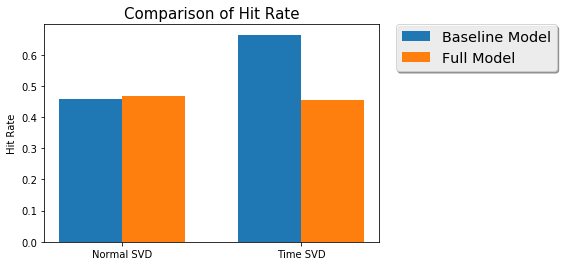

In [54]:
n_groups = 2

svd = [ svd_full,pred_full ]
base = [svd_baseline,pred_baseline]


fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.35



rects1 = ax.bar(index, [base[0],base[1]], bar_width,
                label='Baseline Model')

rects2 = ax.bar(index + bar_width, [svd[0],svd[1]], bar_width,
                label='Full Model')

ax.set_ylabel('Hit Rate')
ax.set_title('Comparison of Hit Rate',fontsize=15)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(['Normal SVD','Time SVD'])
legend = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., shadow=True, fontsize='x-large')

        
plt.show()

In [269]:
def comparison(x,y,parameter):
    fig, ax = plt.subplots()
    ax.plot(x[parameter].unique(), x.groupby(parameter).mean()['rate'],'-o', label='full model')
    ax.plot(y[parameter].unique(), y.groupby(parameter).mean()['rate'],'-o', label='baseline model')  
    legend = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., shadow=True, fontsize='x-large')
    plt.xlabel(parameter)
    plt.ylabel('hit rate')
    if parameter == 'lr':
        parameter = 'learning rate'
    plt.title("{} and hit rate".format(parameter))
    plt.savefig('/Users/nihaozheng/Desktop/Personalization/project/project II/plot/{} and hit rate.png'.format(parameter))
    plt.show()



# Analyze Timestamp of records

In [55]:
time = {}
for person in user_dic2.keys():
    time[person] = []
    t1 = [ i[2] for i in user_dic2[person].purchases_record()]
    t2 = [ i[1]for i in user_dic2[person].carts_record()]
    t3 = [ i[1] for i in user_dic2[person].views_record()]
    time[person] += t1+t2+t3

In [56]:
start_end_time = {}
for person in user_dic2.keys():
    start_end_time[person] = []
    t1 = [ i[2] for i in user_dic2[person].purchases_record()]
    t2 = [ i[1] for i in user_dic2[person].carts_record()]
    t3 = [ i[1] for i in user_dic2[person].views_record()]
    end = max(t1+t2+t3)
    start = min(t1+t2+t3)
    length = (end-start).days
    start_end_time[person] += [start,end,length]

In [57]:
n=0
for person in user_dic2.keys():
    if start_end_time[person][2]==0:
        n+=1
        #print("Customer ID is {}".format(person))
        #print("The date is {}".format(start_end_time[person][1]))
        #print("Purchase history is {}".format(user_dic2[person].purchases_record()))
        #print("Add_to_Cart history is {}".format(user_dic2[person].carts_record())) 
        #print("Views history is {}".format(user_dic2[person].views_record()))
        #print('----------------------------------------------------------------------')
print(n)

344


In [58]:
length = [i[1][2] for i in start_end_time.items()]

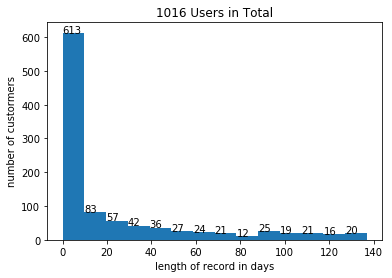

In [59]:
arr=plt.hist(length,bins=14)
for i in range(14):
    plt.text(arr[1][i],arr[0][i],str(int(arr[0][i])))
plt.title("1016 Users in Total")
plt.xlabel('length of record in days')
plt.ylabel('number of custormers')
plt.show()